In [128]:
from modules.one_hot_module import build_df_onehot
from modules.xgboost import XGB_module
from modules.randomForest import RF_module
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [129]:
# df = one.date_to_month_onehot(df, column_name='appointment_datetime')
# df = one.disability_onehot(df)
# df = one.specialty_ko_onehot(df)
df = build_df_onehot()

{'model': LogisticRegression(), 'feature_col': ['gender', 'age', 'appointment_date_Fri', 'appointment_date_Mon', 'appointment_date_Sat', 'appointment_date_Tue', 'appointment_date_Wed', 'appointment_date_Thu', 'appointment_date_Sun'], 'target_col': 'no_show', 'train_score': 0.9025512675601486, 'test_score': 0.9047619047619048, 'train_precision': 0.0, 'train_recall': 0.0, 'train_f1': 0.0, 'test_precision': 0.0, 'test_recall': 0.0, 'test_f1': 0.0}

In [130]:
# 숫자와 불린만 남기고 object나 기타 타입은 제거
df_xgb = df.select_dtypes(include=["int64", "float64", "bool"])

# 컬럼 확인
print(df_xgb.dtypes)

gender                     int64
age                        int64
under_12_years_old         int64
over_60_years_old          int64
patient_needs_companion    int64
                           ...  
icd_z00.1                  int64
icd_z11.2                  int64
icd_z71.2                  int64
icd_z89.4                  int64
icd_null                   int64
Length: 110, dtype: object


In [131]:
# XGB 영역

result_base = XGB_module(
    df=df_xgb,
    target_col="no_show",
    task="classifier",
    imbalance=True,
    threshold=0.5
)

print("Train F1:", result_base['train_f1'])
print("Test F1 :", result_base['test_f1'])
print("Test Precision:", result_base['test_precision'])
print("Test Recall   :", result_base['test_recall'])
print("Test Score (accuracy?):", result_base['test_score'])



[INFO] scale_pos_weight 적용: 9.26
Train F1: 0.4652505671272427
Test F1 : 0.30935672514619883
Test Precision: 0.21084097249900358
Test Recall   : 0.5806805708013172
Test Score (accuracy?): 0.7618471466021375


In [132]:
print("\n=== Threshold Optimization ===")
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
for th in thresholds:
    result_th = XGB_module(
        df=df_xgb,
        target_col="no_show",
        task="classifier",
        imbalance=True,
        threshold=th
    )
    print(f"Threshold={th:.2f}, Test F1={result_th['test_f1']:.3f}, "
          f"Precision={result_th['test_precision']:.3f}, Recall={result_th['test_recall']:.3f}")



=== Threshold Optimization ===
[INFO] scale_pos_weight 적용: 9.26
Threshold=0.40, Test F1=0.271, Precision=0.168, Recall=0.708
[INFO] scale_pos_weight 적용: 9.26
Threshold=0.45, Test F1=0.291, Precision=0.188, Recall=0.644
[INFO] scale_pos_weight 적용: 9.26
Threshold=0.50, Test F1=0.309, Precision=0.211, Recall=0.581
[INFO] scale_pos_weight 적용: 9.26
Threshold=0.55, Test F1=0.324, Precision=0.237, Recall=0.514
[INFO] scale_pos_weight 적용: 9.26
Threshold=0.60, Test F1=0.328, Precision=0.270, Recall=0.417


In [133]:
print("\n=== XGB Parameter Tuning ===")
xgb_params = {
    "n_estimators": 300,
    "max_depth": 5,
    "learning_rate": 0.05,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}
result_tuned = XGB_module(
    df=df_xgb,
    target_col="no_show",
    task="classifier",
    imbalance=True,
    threshold=0.5,
    smote=True,
    smote_k_neighbors=5,
    xgb_params=xgb_params
)
print("Tuned Test F1:", result_tuned['test_f1'])
print("Tuned Test Precision:", result_tuned['test_precision'])
print("Tuned Test Recall:", result_tuned['test_recall'])



=== XGB Parameter Tuning ===
[INFO] scale_pos_weight 적용: 9.26
Tuned Test F1: 0.21611901258786986
Tuned Test Precision: 0.1269688820591625
Tuned Test Recall: 0.725576289791438


In [134]:
result_smote = XGB_module(
    df=df_xgb,
    target_col="no_show",
    task="classifier",
    imbalance=True,
    smote=True,
    smote_k_neighbors=5,
    threshold=0.5
)
print("SMOTE Test F1:", result_smote['test_f1'])
print("SMOTE Test Precision:", result_smote['test_precision'])
print("SMOTE Test Recall:", result_smote['test_recall'])

[INFO] scale_pos_weight 적용: 9.26
SMOTE Test F1: 0.25670410268164107
SMOTE Test Precision: 0.16222479721900349
SMOTE Test Recall: 0.6147091108671789


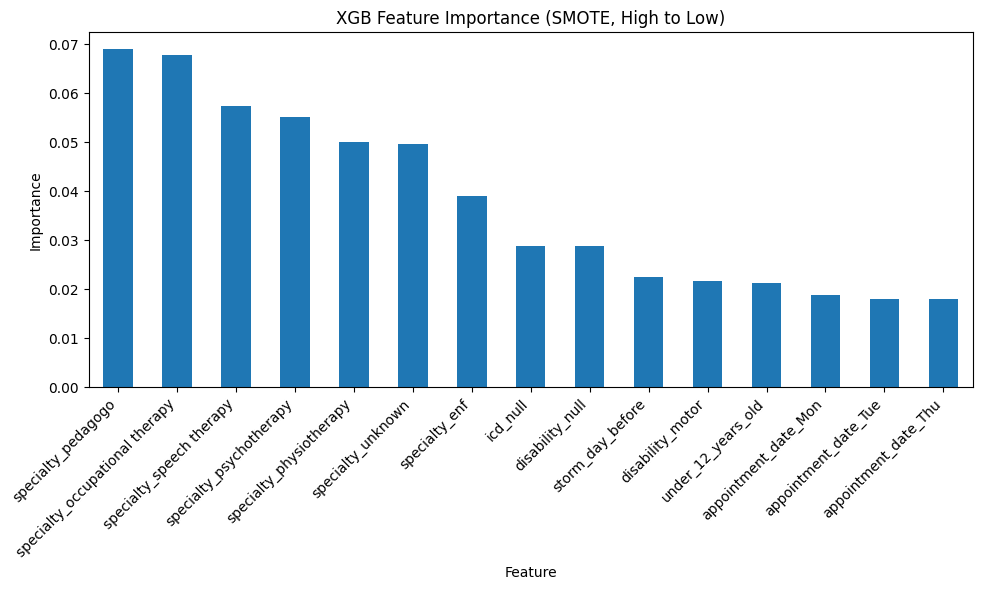

In [135]:
model = result_smote['model']

# 1) Feature Importance
feat_names = model.feature_names_in_  # sklearn >=1.0
feat_importances = pd.Series(model.feature_importances_, index=feat_names)
# 'appointment_id' 제거
feat_importances = feat_importances.loc[[f for f in feat_names if f != 'appointment_id']]
# 높은 순서대로 정렬
feat_importances = feat_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
feat_importances.plot(kind='bar')
plt.title('XGB Feature Importance (SMOTE, High to Low)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


[INFO] scale_pos_weight 적용: 9.26


Text(0, 0.5, 'True Positive Rate')

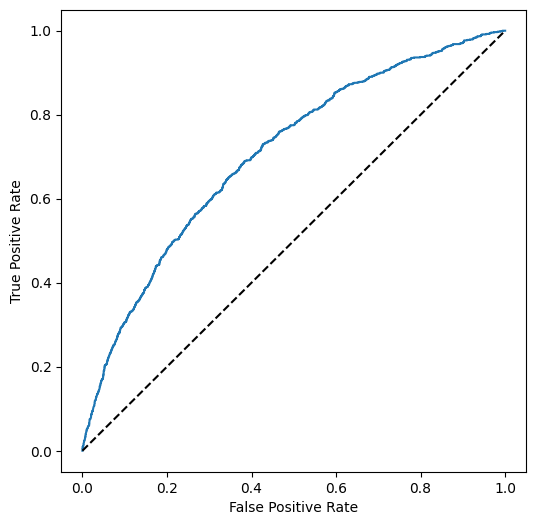

In [136]:
result_smote = XGB_module(
    df=df_xgb,
    target_col="no_show",
    task="classifier",
    imbalance=True,
    smote=True,
    smote_k_neighbors=5,
    threshold=0.5
)
y_test = result_smote['y_test']
y_proba = result_smote['y_proba']

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


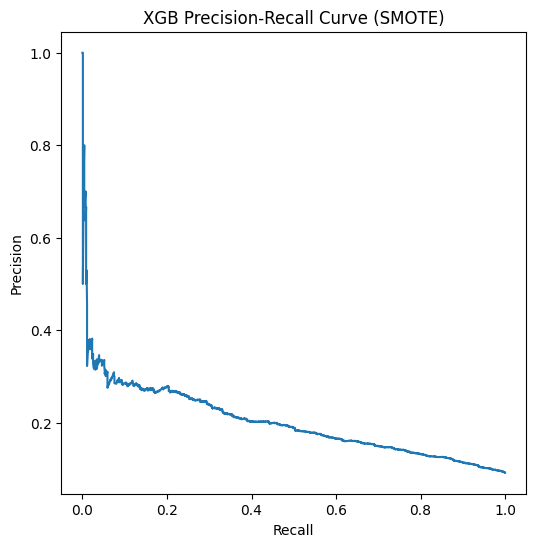

In [137]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGB Precision-Recall Curve (SMOTE)')
plt.show()

In [138]:
# 랜덤포레스트 영역
print("\n=== RF Parameter Tuning ===")

result_rf = RF_module(
    df=df_xgb,
    target_col="no_show",
    task="classifier",
    imbalance=True,
)

y_test = result_rf["y_test"]
y_proba = result_rf["y_proba"]


best_f1 = 0
best_threshold = 0.5

for t in np.linspace(0.3, 0.7, 21):
    y_pred = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    print(f"Threshold={t:.2f}, Test F1={f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred_best = (y_proba >= best_threshold).astype(int)

print("\n=== RF Final Performance ===")
print("RF Test F1       :", f1_score(y_test, y_pred_best))
print("RF Test Precision:", precision_score(y_test, y_pred_best))
print("RF Test Recall   :", recall_score(y_test, y_pred_best))


=== RF Parameter Tuning ===
Threshold=0.30, Test F1=0.3553
Threshold=0.32, Test F1=0.3455
Threshold=0.34, Test F1=0.3422
Threshold=0.36, Test F1=0.3377
Threshold=0.38, Test F1=0.3235
Threshold=0.40, Test F1=0.3180
Threshold=0.42, Test F1=0.3066
Threshold=0.44, Test F1=0.2861
Threshold=0.46, Test F1=0.2776
Threshold=0.48, Test F1=0.2631
Threshold=0.50, Test F1=0.2494
Threshold=0.52, Test F1=0.2402
Threshold=0.54, Test F1=0.2319
Threshold=0.56, Test F1=0.2188
Threshold=0.58, Test F1=0.2073
Threshold=0.60, Test F1=0.1998
Threshold=0.62, Test F1=0.1893
Threshold=0.64, Test F1=0.1836
Threshold=0.66, Test F1=0.1603
Threshold=0.68, Test F1=0.1361
Threshold=0.70, Test F1=0.1173

=== RF Final Performance ===
RF Test F1       : 0.35528500276701713
RF Test Precision: 0.35825892857142855
RF Test Recall   : 0.35236004390779363


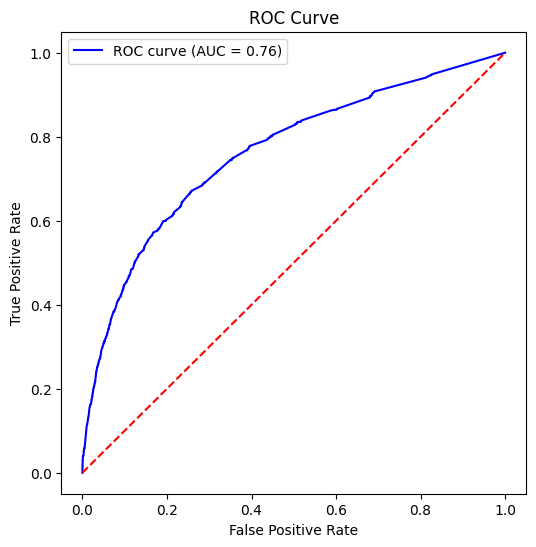

In [139]:
y_test = result_rf['y_test']
y_proba = result_rf['y_proba']

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

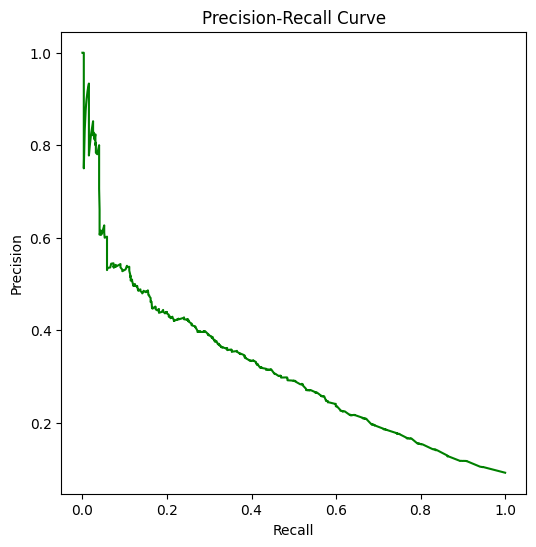

In [140]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

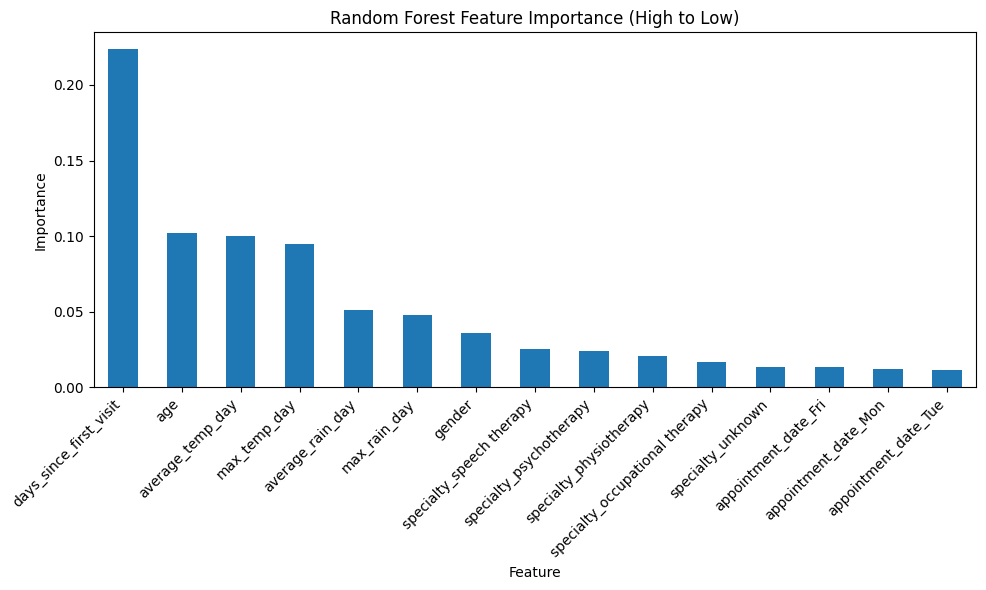

In [141]:
model = result_rf['model']

# 실제 학습에 사용된 컬럼 확인, ID 제거
feat_names = [f for f in model.feature_names_in_ if f != 'appointment_id']

# feature importance 가져오기
feat_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)

# ID 제거 후 높은 순으로 정렬
feat_importances = feat_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
feat_importances.plot(kind='bar')
plt.title('Random Forest Feature Importance (High to Low)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()